In [1]:
# Modules for Data Manipulation/Visualization
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
# Importing pitch data 
pitch_data = pd.read_csv("pitch_data_one_month.csv")
pitch_data.drop("Unnamed: 0", axis = 1, inplace = True)
pitch_data.head()

,GAME_ID,PA_IN_GAME,PITCH_IN_PA,CATCHER_ID,PITCHER_ID,BATTER_ID,UMPIRE_ID,BALLPARK_ID,BALLS,STRIKES,...,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,EXIT_VELOCITY,LAUNCH_ANGLE,SPRAY_ANGLE
0,171,72,5,57,13,2,11,1,3,1,...,10.583700,15.77840,-6.68832,2.09536,0.350211,5.95656,6.33452,86.659058,-4.598840,-12.986703
1,171,25,1,33,480,121,11,1,0,0,...,20.652599,-7.98328,-4.67584,1.20689,-1.451240,5.81709,6.06574,NaN,NaN,NaN
2,171,63,2,57,247,201,11,1,1,0,...,-1.737540,8.00289,-10.34140,4.36072,-2.303100,6.16600,6.14947,NaN,NaN,NaN
3,171,10,4,57,245,312,11,1,3,0,...,14.339600,-6.51659,-5.61544,1.49181,-2.357300,5.16776,6.66450,NaN,NaN,NaN
4,171,11,3,57,245,2,11,1,1,1,...,5.516960,-12.98960,-5.74303,1.26949,-2.258840,5.28204,6.81603,106.085579,-10.664643,10.862201


In [3]:
# Checking data shape/size
pitch_data.shape

(125990, 39)

In [4]:
# Checking Datatypes 
pitch_data.dtypes

GAME_ID                        int64
PA_IN_GAME                     int64
PITCH_IN_PA                    int64
CATCHER_ID                     int64
PITCHER_ID                     int64
BATTER_ID                      int64
UMPIRE_ID                      int64
BALLPARK_ID                    int64
BALLS                          int64
STRIKES                        int64
OUTS                           int64
INNING                         int64
INNING_HALF                   object
AWAY_TEAM_SCORE                int64
HOME_TEAM_SCORE                int64
RUNNER_ON_1B                   int64
RUNNER_ON_2B                   int64
RUNNER_ON_3B                   int64
PITCH_RESULT                  object
EVENT_RESULT                  object
BATTER_SIDE                   object
PITCHER_SIDE                  object
PITCH_TYPE                    object
PITCH_SPEED                  float64
PITCH_LOCATION_SIDE          float64
PITCH_LOCATION_HEIGHT        float64
STRIKE_ZONE_TOP              float64
S

In [5]:
# Creating dataframe with desired target variable -- whether the pitch was called a strike or ball
pitch_data['PITCH_RESULT'].unique()
ball_strike_data = pitch_data.copy()
ball_strike_data = ball_strike_data[(ball_strike_data['PITCH_RESULT'] == 'StrikeCalled') | (ball_strike_data['PITCH_RESULT'] == 'BallCalled')]
ball_strike_data = ball_strike_data.reset_index()
ball_strike_data.drop('index', axis = 1, inplace = True)

In [6]:
# Checking size of new dataframe 
ball_strike_data.shape

(65925, 39)

In [7]:
# Checking for Na values in target variable 
ball_strike_data['PITCH_RESULT'].isnull().any()
print(list(ball_strike_data['PITCH_RESULT'].unique()))

['BallCalled', 'StrikeCalled']


In [8]:
# Dropping Unecessary Columns 
# 1) We are predicting the probability that a pitch was a called strike or a ball -- Exit velocity/launch angle don't come into play  
exit_velocity_cols = ['EXIT_VELOCITY', 'LAUNCH_ANGLE', 'SPRAY_ANGLE']
ball_strike_data.drop(exit_velocity_cols, axis = 1, inplace = True)

# 2) Ballpark features likely don't come into play 
ball_strike_data.drop('BALLPARK_ID', axis = 1, inplace = True)

# 3) GAME_ID 
ball_strike_data.drop('GAME_ID', axis = 1, inplace=True)

# 4) EVENT_RESULT -- Not interested in the result of the at bat 
ball_strike_data.drop('EVENT_RESULT', axis = 1, inplace=True)

# 5) Assumption: game situation will not bias the umpire frequently enough to make a signifigant impact on ball/strike call in general 
game_situation_cols = ['PA_IN_GAME', 'PITCH_IN_PA', 'INNING', 'INNING_HALF', 'AWAY_TEAM_SCORE', 'HOME_TEAM_SCORE', 
    'RUNNER_ON_1B', 'RUNNER_ON_2B', 'RUNNER_ON_3B']
ball_strike_data.drop(game_situation_cols, axis = 1, inplace=True)

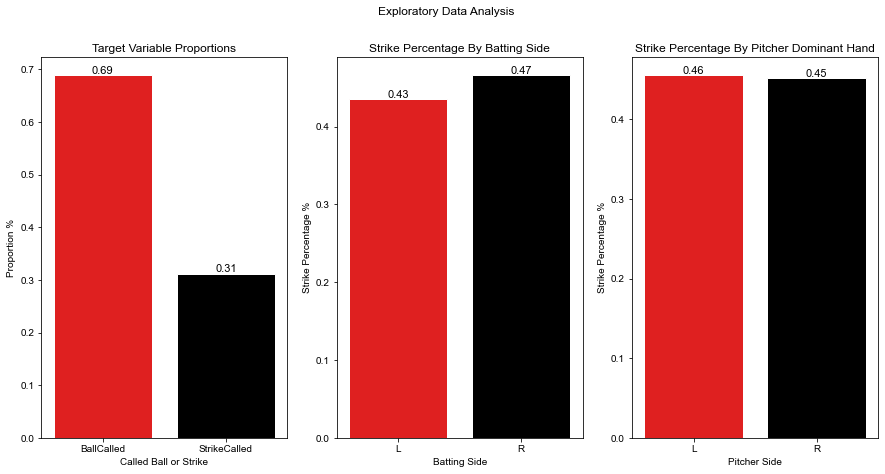

In [10]:
# Data Exploration 
fig, axes = plt.subplots(1, 3, figsize=(15,7))
plt.suptitle('Exploratory Data Analysis')
sns.set_style('darkgrid')

DF = pd.DataFrame(ball_strike_data['PITCH_RESULT'].value_counts()).reset_index()
DF = DF.rename(columns = {'index':'PITCH_RESULT', 'PITCH_RESULT': 'COUNT'})
DF['PCT'] = DF['COUNT'] / DF['COUNT'].sum()
colr = ['red', 'black']
ax = sns.barplot(x = DF['PITCH_RESULT'], y = DF['PCT'], palette = colr, ax = axes[0])
_ = ax.set_title('Target Variable Proportions')
_ = ax.set(xlabel = 'Called Ball or Strike', ylabel = 'Proportion %')
for p in ax.patches:
    ax.annotate("%.2f"  % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0,5),
                textcoords='offset points')


DF = ball_strike_data.copy()
DF['PITCH_RESULT'] = np.where(DF['PITCH_RESULT'] == 'StrikeCalled', 1, 0)
x = DF.groupby('BATTER_SIDE')['PITCH_RESULT'].sum()
x = pd.DataFrame(x)
x.reset_index(inplace = True)
x['TOTAL_PITCHES'] = ''
x.iloc[0, 2] = len(DF[DF['BATTER_SIDE'] == 'L'].index) - x.iloc[0, 1]
x.iloc[1, 2] = len(DF[DF['BATTER_SIDE'] == 'R'].index) - x.iloc[1,1]
x['STRIKE_PCT'] = x['PITCH_RESULT'] / x['TOTAL_PITCHES']
ax1 = sns.barplot(x = x['BATTER_SIDE'], y = x['STRIKE_PCT'], palette = colr, ax = axes[1])
_ = ax1.set_title('Strike Percentage By Batting Side')
_ = ax1.set(xlabel = 'Batting Side', ylabel = 'Strike Percentage %')
for p in ax1.patches:
    ax1.annotate("%.2f"  % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0,5),
                textcoords='offset points')

DF = ball_strike_data.copy()
DF['PITCH_RESULT'] = np.where(DF['PITCH_RESULT'] == 'StrikeCalled', 1, 0)
x = DF.groupby('PITCHER_SIDE')['PITCH_RESULT'].sum()
x = pd.DataFrame(x)
x.reset_index(inplace = True)
x['TOTAL_PITCHES'] = ''
x.iloc[0, 2] = len(DF[DF['PITCHER_SIDE'] == 'L'].index) - x.iloc[0, 1]
x.iloc[1, 2] = len(DF[DF['PITCHER_SIDE'] == 'R'].index) - x.iloc[1,1]
x['STRIKE_PCT'] = x['PITCH_RESULT'] / x['TOTAL_PITCHES']
ax2 = sns.barplot(x = x['PITCHER_SIDE'], y = x['STRIKE_PCT'], palette = colr, ax = axes[2])
_ = ax2.set_title('Strike Percentage By Pitcher Dominant Hand')
_ = ax2.set(xlabel = 'Pitcher Side', ylabel = 'Strike Percentage %')
for p in ax2.patches:
    ax2.annotate("%.2f"  % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0,5),
                textcoords='offset points')



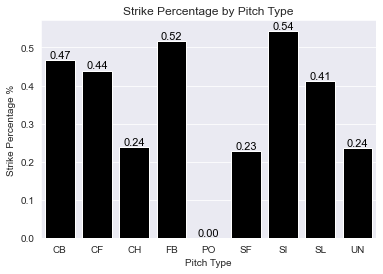

In [11]:
# Data Exploration 
DF = ball_strike_data.copy()
DF['PITCH_RESULT'] = np.where(DF['PITCH_RESULT'] == 'StrikeCalled', 1, 0)
x = DF.groupby('PITCH_TYPE')['PITCH_RESULT'].sum()
x = pd.DataFrame(x)
x.reset_index(inplace = True)
x['TOTAL_PITCHES'] = ''
x.iloc[0, 2] = len(DF[DF['PITCH_TYPE'] == 'CB'].index) - x.iloc[0, 1]
x.iloc[1, 2] = len(DF[DF['PITCH_TYPE'] == 'CF'].index) - x.iloc[1, 1]
x.iloc[2, 2] = len(DF[DF['PITCH_TYPE'] == 'CH'].index) - x.iloc[2, 1]
x.iloc[3, 2] = len(DF[DF['PITCH_TYPE'] == 'FB'].index) - x.iloc[3, 1]
x.iloc[4, 2] = len(DF[DF['PITCH_TYPE'] == 'PO'].index) - x.iloc[4, 1]
x.iloc[5, 2] = len(DF[DF['PITCH_TYPE'] == 'SF'].index) - x.iloc[5, 1]
x.iloc[6, 2] = len(DF[DF['PITCH_TYPE'] == 'SI'].index) - x.iloc[6, 1]
x.iloc[7, 2] = len(DF[DF['PITCH_TYPE'] == 'SL'].index) - x.iloc[7, 1]
x.iloc[8, 2] = len(DF[DF['PITCH_TYPE'] == 'UN'].index) - x.iloc[8, 1]
x['STRIKE_PCT'] = x['PITCH_RESULT'] / x['TOTAL_PITCHES']

ax = sns.barplot(x = x['PITCH_TYPE'], y = x['STRIKE_PCT'], color = 'black')
_ = ax.set_title('Strike Percentage by Pitch Type')
_ = ax.set(xlabel = 'Pitch Type', ylabel = 'Strike Percentage %')
for p in ax.patches:
    ax.annotate("%.2f"  % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0,5),
                textcoords='offset points')


In [13]:
# Feature Engineering 
# Adding Count 
ball_strike_data['COUNT'] = ball_strike_data['BALLS'].astype(str) + '-' + ball_strike_data['STRIKES'].astype(str)

# Binning Velocity 
ball_strike_data['VELOCITY_ESTIMATION'] = pd.cut(ball_strike_data['PITCH_SPEED'], 5, labels = ['50-59 MPH', '60-69 MPH', '70-79 MPH',
'80-89 MPH', '90+ MPH'])
ball_strike_data['VELOCITY_ESTIMATION'] = np.where(ball_strike_data['VELOCITY_ESTIMATION'].isna() == True, 'UNKNOWN', ball_strike_data['VELOCITY_ESTIMATION'])

# High or Low Pitch 
ball_strike_data['HIGH_LOW'] = np.where(ball_strike_data['PITCH_LOCATION_HEIGHT'] > 0, 'HIGH', 'LOW')

# Inside or Outside Pitch 
ball_strike_data['INSIDE_OUTSIDE'] = np.where(ball_strike_data['PITCH_LOCATION_SIDE'] > 0, 'OUTSIDE', 'INSIDE')

In [15]:
# Saving the New dataframe as a csv for later 
ball_strike_data.to_csv('ball_strike_data_v1.csv')

In [16]:
# Checking for NA values in Remaining Features
na_df = pd.DataFrame(ball_strike_data.isna().sum()).reset_index()
na_df = na_df.rename(columns = {"index" : "FEATURE", 0 : 'NUM_MISSING'})

na_df = na_df[na_df['NUM_MISSING'] > 0]
na_df['PCT_MISSING'] = na_df['NUM_MISSING'] / 65925 * 100 
na_df = na_df.sort_values('PCT_MISSING', ascending = False)
na_df.head(100)

,FEATURE,NUM_MISSING,PCT_MISSING
16,SPIN_RATE,1369,2.076602
17,INDUCED_VERTICAL_BREAK,203,0.307926
18,HORIZONTAL_BREAK,203,0.307926
21,RELEASE_SIDE,203,0.307926
22,RELEASE_HEIGHT,203,0.307926
23,RELEASE_EXTENSION,203,0.307926
12,PITCH_LOCATION_SIDE,202,0.306409
13,PITCH_LOCATION_HEIGHT,202,0.306409
19,VERTICAL_APPROACH_ANGLE,202,0.306409
20,HORIZONTAL_APPROACH_ANGLE,202,0.306409


In [17]:
# Using Knn Imputation to Fill in Missing Values 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

impute_df = ball_strike_data.copy()
impute_df.drop(['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID'], axis = 1, inplace = True)

In [18]:
# Using Knn Imputation to Fill in Missing Values - Dummy Vars
impute_df.drop('PITCH_RESULT', axis = 1, inplace=True)
impute_cat_vars = impute_df[['BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_TYPE', 'COUNT', 'VELOCITY_ESTIMATION', 'HIGH_LOW', 'INSIDE_OUTSIDE']]
impute_cat_dummies = pd.get_dummies(impute_cat_vars, drop_first=True)

In [21]:
# Using Knn Imputation to Fill in Missing Values - Dummy Vars
impute_df.drop(['BATTER_SIDE', 'PITCHER_SIDE', 'PITCH_TYPE', 'COUNT', 'VELOCITY_ESTIMATION', 'HIGH_LOW', 'INSIDE_OUTSIDE'], axis = 1, inplace=True)
impute_df = pd.concat([impute_df, impute_cat_dummies], axis = 1)

In [22]:
# Using Knn Imputation to Fill in Missing Values - Scaling 
scaler = MinMaxScaler()
impute_df = pd.DataFrame(scaler.fit_transform(impute_df), columns = impute_df.columns)
impute_df.head()

,BALLS,STRIKES,OUTS,PITCH_SPEED,PITCH_LOCATION_SIDE,PITCH_LOCATION_HEIGHT,STRIKE_ZONE_TOP,STRIKE_ZONE_BOTTOM,SPIN_RATE,INDUCED_VERTICAL_BREAK,...,COUNT_3-0,COUNT_3-1,COUNT_3-2,VELOCITY_ESTIMATION_60-69 MPH,VELOCITY_ESTIMATION_70-79 MPH,VELOCITY_ESTIMATION_80-89 MPH,VELOCITY_ESTIMATION_90+ MPH,VELOCITY_ESTIMATION_UNKNOWN,HIGH_LOW_LOW,INSIDE_OUTSIDE_OUTSIDE
0,0.333333,0.0,1.0,0.594946,0.605555,0.350555,0.615385,0.615385,NaN,0.394707,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.0,0.5,0.818829,0.444070,0.445504,0.307692,0.307692,0.527362,0.682649,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,0.0,0.5,0.917076,0.617159,0.467867,0.615385,0.615385,0.467475,0.648539,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.000000,0.5,0.5,0.738677,0.590148,0.463251,0.153846,0.153846,0.629884,0.465891,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.333333,0.5,1.0,0.599972,0.468978,0.454060,0.461538,0.461539,0.534012,0.446816,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Using Knn Imputation to Fill in Missing Values - Imputing 
imputer = KNNImputer(n_neighbors=5)
impute_df = pd.DataFrame(imputer.fit_transform(impute_df),columns = impute_df.columns)
impute_df.isna().any()

BALLS                            False
STRIKES                          False
OUTS                             False
PITCH_SPEED                      False
PITCH_LOCATION_SIDE              False
PITCH_LOCATION_HEIGHT            False
STRIKE_ZONE_TOP                  False
STRIKE_ZONE_BOTTOM               False
SPIN_RATE                        False
INDUCED_VERTICAL_BREAK           False
HORIZONTAL_BREAK                 False
VERTICAL_APPROACH_ANGLE          False
HORIZONTAL_APPROACH_ANGLE        False
RELEASE_SIDE                     False
RELEASE_HEIGHT                   False
RELEASE_EXTENSION                False
BATTER_SIDE_R                    False
PITCHER_SIDE_R                   False
PITCH_TYPE_CF                    False
PITCH_TYPE_CH                    False
PITCH_TYPE_FB                    False
PITCH_TYPE_PO                    False
PITCH_TYPE_SF                    False
PITCH_TYPE_SI                    False
PITCH_TYPE_SL                    False
PITCH_TYPE_UN            

In [24]:
# Filling in missing values in main dataframe
ball_strike_data[['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID']] = ball_strike_data[['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID']].astype(str)
ball_strike_data = ball_strike_data[['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID', 'PITCH_RESULT']]
ball_strike_data = pd.concat([ball_strike_data, impute_df], axis = 1)
ball_strike_data.head()

,CATCHER_ID,PITCHER_ID,BATTER_ID,UMPIRE_ID,PITCH_RESULT,BALLS,STRIKES,OUTS,PITCH_SPEED,PITCH_LOCATION_SIDE,...,COUNT_3-0,COUNT_3-1,COUNT_3-2,VELOCITY_ESTIMATION_60-69 MPH,VELOCITY_ESTIMATION_70-79 MPH,VELOCITY_ESTIMATION_80-89 MPH,VELOCITY_ESTIMATION_90+ MPH,VELOCITY_ESTIMATION_UNKNOWN,HIGH_LOW_LOW,INSIDE_OUTSIDE_OUTSIDE
0,57,247,201,11,BallCalled,0.333333,0.0,1.0,0.594946,0.605555,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,57,245,312,11,BallCalled,1.000000,0.0,0.5,0.818829,0.444070,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,33,60,264,11,BallCalled,0.000000,0.0,0.5,0.917076,0.617159,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,33,480,455,11,StrikeCalled,0.000000,0.5,0.5,0.738677,0.590148,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,33,60,425,11,StrikeCalled,0.333333,0.5,1.0,0.599972,0.468978,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Creating Dummy Variables for IDs
IDs = ball_strike_data[['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID']]
ball_strike_data.drop(['CATCHER_ID', 'PITCHER_ID', 'BATTER_ID', 'UMPIRE_ID'], axis = 1, inplace=True)
ID_dummies = pd.get_dummies(IDs, drop_first=True)

In [26]:
# Creating Dummy Variables for IDs
ball_strike_data = pd.concat([ID_dummies, ball_strike_data], axis = 1)

In [27]:
# Cross Validation for Model Selection 
# Models : Logistic Regression, Decision Tree, Random Forest, and Xgboost 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Inputs and Target Variables
target = ball_strike_data['PITCH_RESULT']
target = np.where(target == "BallCalled", 0, 1)
inputs = ball_strike_data.drop('PITCH_RESULT', axis = 1)

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=0)

# Classifiers 
LogR = LogisticRegression(max_iter=1000)
tree = tree.DecisionTreeClassifier()
RF = RandomForestClassifier()
XGB = XGBClassifier(eval_metric='mlogloss', use_label_encoder =False)

clfs = [LogR, tree, RF, XGB]
names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
i =  0
for clf in clfs: 
    mean_cv_score = cross_val_score(clf, x_train, y_train, cv=10).mean()
    print(names[i], ":", mean_cv_score)
    i = i + 1

Logistic Regression : 0.6916382252559726
Decision Tree : 0.9015927189988624
Random Forest : 0.9026924535456958
XGBoost : 0.9303564656806979


In [25]:
# Parameter Tuning Xgboost Model 
from hyperopt import hp, Trials, tpe, fmin, STATUS_OK
params={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [26]:
# Parameter Tuning Xgboost Model 
from sklearn.metrics import accuracy_score
def obj(params): 
    XGB = XGBClassifier(eval_metric='mlogloss', 
                        use_label_encoder =False, 
                        n_estimators = params['n_estimators'], 
                        max_depth = int(params['max_depth']), 
                        gamma = params['gamma'], 
                        reg_alpha = int(params['reg_alpha']), 
                        min_child_weight = int(params['min_child_weight']), 
                        colsample_bytree = params['colsample_bytree'])
    
    evaluation = [(x_train, y_train), (x_test, y_test)]

    XGB.fit(x_train, y_train, eval_set = evaluation, eval_metric = 'auc')

    pred = XGB.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [27]:
# Parameter Tuning Xgboost Model
trials = Trials()

best_hyperparams = fmin(fn = obj,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 75,
                        trials = trials)



[8]	validation_0-auc:0.97911	validation_1-auc:0.97745

[9]	validation_0-auc:0.97959	validation_1-auc:0.97794

[10]	validation_0-auc:0.97955	validation_1-auc:0.97778

[11]	validation_0-auc:0.98007	validation_1-auc:0.97841

[12]	validation_0-auc:0.98082	validation_1-auc:0.97907

[13]	validation_0-auc:0.98113	validation_1-auc:0.97945

[14]	validation_0-auc:0.98140	validation_1-auc:0.97971

[15]	validation_0-auc:0.98159	validation_1-auc:0.97980

[16]	validation_0-auc:0.98168	validation_1-auc:0.97994

[17]	validation_0-auc:0.98183	validation_1-auc:0.98005

[18]	validation_0-auc:0.98185	validation_1-auc:0.98005

[19]	validation_0-auc:0.98199	validation_1-auc:0.98014

[20]	validation_0-auc:0.98204	validation_1-auc:0.98015

[21]	validation_0-auc:0.98212	validation_1-auc:0.98027

[22]	validation_0-auc:0.98222	validation_1-auc:0.98035

[23]	validation_0-auc:0.98223	validation_1-auc:0.98037

[24]	validation_0-auc:0.98227	validation_1-auc:0.98042

[25]	validation_0-auc:0.98230	validation_1-auc:0

In [28]:
# Best Parameters
print(best_hyperparams)

{'colsample_bytree': 0.657144085193371, 'gamma': 1.790817646698505, 'max_depth': 17.0, 'min_child_weight': 2.0, 'reg_alpha': 56.0, 'reg_lambda': 0.4398592857607118}


In [28]:
# Training the Model with Best Parameters 
XGB = XGBClassifier(eval_metric='mlogloss', 
                        use_label_encoder =False, 
                        max_depth = 17, 
                        gamma = 1.790817646698505, 
                        reg_alpha = 56, 
                        reg_lambda = 0.4398592857607118,
                        min_child_weight = 2, 
                        colsample_bytree = 0.657144085193371)

XGB.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.657144085193371,
              eval_metric='mlogloss', gamma=1.790817646698505, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=17,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=56, reg_lambda=0.4398592857607118, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [29]:
# Checking Accuracy on Held out Data
XGB_acc = XGB.score(x_test, y_test)
print(XGB_acc)

0.929161926431551


In [30]:
# Reporting Probabilities Using the Full Dataset
strike_probs = XGB.predict_proba(inputs)

In [81]:
called_strike_df = pd.read_csv('ball_strike_data_v1.csv')

In [82]:
called_strike_df.drop("Unnamed: 0", axis = 1, inplace = True)
called_strike_df.head()

,CATCHER_ID,PITCHER_ID,BATTER_ID,UMPIRE_ID,BALLS,STRIKES,OUTS,PITCH_RESULT,BATTER_SIDE,PITCHER_SIDE,...,HORIZONTAL_BREAK,VERTICAL_APPROACH_ANGLE,HORIZONTAL_APPROACH_ANGLE,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,COUNT,VELOCITY_ESTIMATION,HIGH_LOW,INSIDE_OUTSIDE
0,57,247,201,11,1,0,2,BallCalled,R,R,...,8.00289,-10.34140,4.36072,-2.30310,6.16600,6.14947,1-0,70-79 MPH,HIGH,OUTSIDE
1,57,245,312,11,3,0,1,BallCalled,L,R,...,-6.51659,-5.61544,1.49181,-2.35730,5.16776,6.66450,3-0,90+ MPH,HIGH,INSIDE
2,33,60,264,11,0,0,1,BallCalled,R,R,...,-5.19421,-6.45850,2.87823,-1.93630,6.33530,6.94000,0-0,90+ MPH,HIGH,OUTSIDE
3,33,480,455,11,0,1,1,StrikeCalled,R,R,...,-1.98908,-7.63072,2.51436,-1.62822,5.89561,5.63657,0-1,80-89 MPH,HIGH,OUTSIDE
4,33,60,425,11,1,1,2,StrikeCalled,R,R,...,5.74457,-8.92454,2.46940,-1.97510,6.40042,6.13104,1-1,70-79 MPH,HIGH,INSIDE


In [83]:
called_strike_df['STRIKE_PROBS'] = strike_probs[:,1]
called_strike_df['CALLED_STRIKE'] = np.where(called_strike_df['STRIKE_PROBS'] >= 0.5, 1, 0)

In [90]:
# Grouping to determine which pitcher lost the most strikes 
pitcher_loss_strike = called_strike_df.groupby('PITCHER_ID')['PITCH_RESULT', 'CALLED_STRIKE'].sum().reset_index()

<ipython-input-90-14b00fb9ef22>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pitcher_loss_strike = called_strike_df.groupby('PITCHER_ID')['PITCH_RESULT', 'CALLED_STRIKE'].sum().reset_index()


In [94]:
pitcher_loss_strike['LOSS_STRIKES'] = pitcher_loss_strike['CALLED_STRIKE'] - pitcher_loss_strike['PITCH_RESULT']
pitcher_loss_strike.sort_values('LOSS_STRIKES', ascending = False)

,PITCHER_ID,PITCH_RESULT,CALLED_STRIKE,LOSS_STRIKES
495,497,68,78,10
56,57,88,96,8
191,192,77,85,8
62,63,58,66,8
457,459,76,84,8
...,...,...,...,...
24,25,83,71,-12
158,159,59,47,-12
296,298,53,40,-13
252,254,105,92,-13


In [95]:
called_strike_df.to_csv("called_strike_data.csv")